In [208]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
for dirname, _, filenames in os.walk('./malicious-connection-dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./malicious-connection-dataset/df_bad.csv
./malicious-connection-dataset/df_good.csv


In [3]:
#Load data
df_bad = pd.read_csv('./malicious-connection-dataset/df_bad.csv', encoding='ISO-8859-2')
df_bad.rename(columns={'Unnamed: 0':'unnamed'}, inplace=True)
df_bad.drop('unnamed', axis=1, inplace=True)
df_bad.insert(0, 'label', 0)

df_good = pd.read_csv('./malicious-connection-dataset/df_good.csv', encoding='ISO-8859-2')  
df_good.rename(columns={'Unnamed: 0':'unnamed'}, inplace=True)
df_good.drop('unnamed', axis=1, inplace=True)
df_good.insert(0, 'label', 1)
df = pd.concat([df_good, df_bad], ignore_index=True)
print(df.head())

   label                ip     port  \
0      1   54.192.93.196\n  https\n   
1      1  172.217.20.196\n  https\n   
2      1   146.0.227.107\n  https\n   
3      1    52.0.187.208\n  https\n   
4      1   54.192.93.166\n  https\n   

                                               times  \
0  2544744290,2544851375|2544851389,2544957774,25...   
1  4025706292,4026084367,4026376491,4026463221,40...   
2  3046049650,3046060847|3046060884,3046063766,30...   
3  180493736,180616162|180616174,180641699,180773...   
4  1442442427,1442737731,1442755056|1442755755,14...   

                                                  di  \
0  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...   
1  0,0,0,0,188,0,0,0,0,0,0,0,126,0,0,0,1368,0,0,0...   
2                            0,0,0,0,0,0,0,0,0,0,0\n   
3  0,0,0,0,0,0,0,0,0,0,0,0,465,224,0,0,0,0,0,0,0,...   
4  0,0,192,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...   

                                                  do  \
0  0,0,182,4024,126,382,226,0,497,0

In [4]:
#Feature engineering - times, aggregate via std
def time_converter(s):
    s = s.fillna(0).astype(str).str.split("|", expand = False).apply(
            lambda x : [[int(i) for i in y.split(',')] for y in x]
        )
    s = s.apply(lambda x : np.std(np.concatenate(x)))
    return s
df[['times']] = df[['times']].apply(time_converter, axis=0)

In [5]:
#Feature engineering - other numerical aggreagted via std
def num_converter(s):
    s = s.fillna(0).astype(str).str.split(",", expand = False).apply(
            lambda x : [int(y) for y in x]
        )
    s = s.apply(lambda x : np.std(x))
    return s
df[['di']] = df[['di']].apply(num_converter, axis=0)
df[['do']] = df[['do']].apply(num_converter, axis=0)
df[['pi']] = df[['pi']].apply(num_converter, axis=0)
df[['po']] = df[['po']].apply(num_converter, axis=0)

In [28]:
#Feature engineering - encode categorical
cols = ['ip', 'port']
print(df[['ip']])
# import labelencoder
from sklearn.preprocessing import LabelEncoder# instantiate labelencoder object
le = LabelEncoder()
df[cols] = df[cols].apply(lambda col: le.fit_transform(col))

              ip
0       0.847820
1      -0.680141
2      -1.041982
3       0.790188
4       0.847552
...          ...
274148 -1.748161
274149  1.330811
274150 -0.661142
274151 -0.661185
274152 -0.661170

[274153 rows x 1 columns]


In [29]:
#Feature normalization
cols = ['times', 'di', 'do', 'pi', 'po', 'ip', 'port']
df[cols] = (df[cols]-df[cols].mean())/df[cols].std()

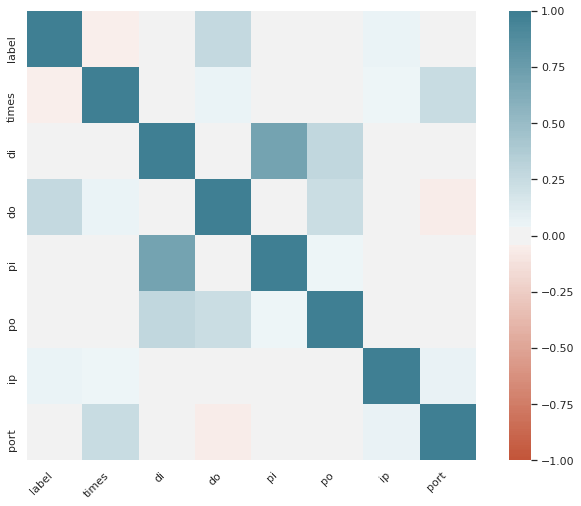

In [209]:
#Plot corellation
cols = ['label', 'times', 'di', 'do', 'pi', 'po', 'ip', 'port']
corr = df[cols].corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [147]:
#Train Test split
from sklearn.model_selection import train_test_split
#Feature selection via cheap classifier
X = df[['ip', 'port', 'times', 'di', 'do', 'pi', 'po']]
y = df[['label']]
print(X.shape)
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.33, random_state=42, shuffle=True, stratify=y)

#Feature selection via cheap classifier
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X_train, y_train)
print(clf.feature_importances_)  
model = SelectFromModel(clf, prefit=True, threshold='0.5*mean')
X_train = model.transform(X_train)
X_test = model.transform(X_test)
print(X_train.shape)

(274153, 7)


/home/lorenz/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


[0.12299251 0.10093025 0.08103465 0.06003645 0.39078752 0.12959524
 0.11462339]
(183682, 7)


In [152]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [2, 20, 40],
    'max_features': [1, 3, 7],
    'min_samples_leaf': [2, 4, 8],
    'min_samples_split': [5, 10, 10],
    'n_estimators': [5, 25, 50]
}# Create a based model
rf = RandomForestClassifier()# Instantiate the grid search model
clf = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

#clf = RandomForestClassifier(max_depth=20, max_features=7, random_state=0)
clf.fit(X_train, y_train)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done 729 out of 729 | elapsed: 22.2min finished
/home/lorenz/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [159]:
y_pred = (clf.predict(X_test))

In [160]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
target_names = ['good', 'bad']
print(classification_report(y_test, y_pred, target_names=target_names))
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

        good       0.99      1.00      0.99     82202
         bad       0.96      0.94      0.95      8269

    accuracy                           0.99     90471
   macro avg       0.97      0.97      0.97     90471
weighted avg       0.99      0.99      0.99     90471

0.9904941915088813
[[81840   362]
 [  498  7771]]


In [1]:
X_pred_bad = X_test[np.where(y_pred == 1)]
X_pred_good = X_test[np.where(y_pred == 0)]

from sklearn.cluster import OPTICS
clustering = OPTICS(min_samples=2).fit(X_pred_bad)


NameError: name 'X_test' is not defined

In [ ]:
print(len(set(clustering.labels_)))